In [2]:
!git clone https://github.com/MikeOfZen/Yet-Another-Openpose-Implementation.git

fatal: destination path 'Yet-Another-Openpose-Implementation' already exists and is not an empty directory.


In [1]:
cd /content/Yet-Another-Openpose-Implementation

/content/Yet-Another-Openpose-Implementation


In [ ]:
pip install -r requirements.txt

In [2]:
import cv2
import visualizations as vis
from applications.model_wrapper import ModelWrapper
import configs.draw_config as draw_config

/content/Yet-Another-Openpose-Implementation/post_processing/post.py:110: NumbaDeprecationWarning: The 'numba.jitclass' decorator has moved to 'numba.experimental.jitclass' to better reflect the experimental nature of the functionality. Please update your imports to accommodate this change and see https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#change-of-jitclass-location for the time frame.
  @numba.jitclass(spec)


In [3]:
model_path = "/content/Yet-Another-Openpose-Implementation/trained_models/model11_test-15Sun1219-2101"

In [5]:
import tensorflow as tf
import post_processing.post as post
import configs.post_config as post_config
import configs.keypoints_config as kpts_config
import configs.default_config as def_config

post.Skeletonizer.config(kpts_config.KEYPOINTS_DEF, kpts_config.JOINTS_DEF, post_config)
post.Skeleton.config(kpts_config.KEYPOINTS_DEF, kpts_config.JOINTS_DEF)


class ModelWrapperCust:
    def __init__(self, model_path):
        self.model = tf.keras.models.load_model(model_path)

    def process_image(self, img):
        input_img = tf.image.resize(img, (def_config.IMAGE_HEIGHT, def_config.IMAGE_WIDTH))
        input_img = tf.image.convert_image_dtype(input_img, dtype=tf.float32)
        input_img /= 255
        input_img = input_img[tf.newaxis, ...]
        pafs, kpts = self.model.predict(input_img)
        pafs = pafs[0]
        kpts = kpts[0]
        skeletonizer = post.Skeletonizer(kpts, pafs)
        skeletons = skeletonizer.create_skeletons()
        return skeletons, kpts, pafs


In [6]:
model_wrapper = ModelWrapperCust(model_path)

In [57]:
imaga = cv2.imread('/content/Pic3.jpg')
imaga = cv2.cvtColor(imaga, cv2.COLOR_BGR2RGB)

In [58]:
import numpy as np
skeletons, heat_maps, pafs = model_wrapper.process_image(imaga)

In [69]:
import collections
KEYPOINTS_DEF={
 'nose'         :{"idx":0   ,"name":'nose'         ,"side":"C"   ,"ds_idxs":0    ,"mirror_name":None       },
 'sternum'      :{"idx":1   ,"name":'sternum'      ,"side":"C"   ,"ds_idxs":(5,6),"mirror_name":None       },
 'Rshoulder'    :{"idx":2   ,"name":'Rshoulder'    ,"side":"R"   ,"ds_idxs":6    ,"mirror_name":'Lshoulder'},
 'Relbow'       :{"idx":3   ,"name":'Relbow'       ,"side":"R"   ,"ds_idxs":8    ,"mirror_name":'Lelbow'   },
 'Rwrist'       :{"idx":4   ,"name":'Rwrist'       ,"side":"R"   ,"ds_idxs":10   ,"mirror_name":'Lwrist'   },
 'Rhip'         :{"idx":5   ,"name":'Rhip'         ,"side":"R"   ,"ds_idxs":12   ,"mirror_name":'Lhip'     },
 'Rknee'        :{"idx":6   ,"name":'Rknee'        ,"side":"R"   ,"ds_idxs":14   ,"mirror_name":'Lknee'    },
 'Rankle'       :{"idx":7   ,"name":'Rankle'       ,"side":"R"   ,"ds_idxs":16   ,"mirror_name":'Lankle'   },
 'Reye'         :{"idx":8   ,"name":'Reye'         ,"side":"R"   ,"ds_idxs":2    ,"mirror_name":'Leye'     },
 'Rear'         :{"idx":9   ,"name":'Rear'         ,"side":"R"   ,"ds_idxs":4    ,"mirror_name":'Lear'     },
 'Lshoulder'    :{"idx":10  ,"name":'Lshoulder'    ,"side":"L"   ,"ds_idxs":5    ,"mirror_name":'Rshoulder'},
 'Lelbow'       :{"idx":11  ,"name":'Lelbow'       ,"side":"L"   ,"ds_idxs":7    ,"mirror_name":'Relbow'   },
 'Lwrist'       :{"idx":12  ,"name":'Lwrist'       ,"side":"L"   ,"ds_idxs":9    ,"mirror_name":'Rwrist'   },
 'Lhip'         :{"idx":13  ,"name":'Lhip'         ,"side":"L"   ,"ds_idxs":11   ,"mirror_name":'Rhip'     },
 'Lknee'        :{"idx":14  ,"name":'Lknee'        ,"side":"L"   ,"ds_idxs":13   ,"mirror_name":'Rknee'    },
 'Lankle'       :{"idx":15  ,"name":'Lankle'       ,"side":"L"   ,"ds_idxs":15   ,"mirror_name":'Rankle'   },
 'Leye'         :{"idx":16  ,"name":'Leye'         ,"side":"L"   ,"ds_idxs":1    ,"mirror_name":'Reye'     },
 'Lear'         :{"idx":17  ,"name":'Lear'         ,"side":"L"   ,"ds_idxs":3    ,"mirror_name":'Rear'     }
        }
KEYPOINTS_DEF=collections.OrderedDict(sorted(KEYPOINTS_DEF.items(), key=lambda t: t[1]["idx"]))

In [71]:
    def _localize_potential_kpts(KEYPOINTS_DEF, kpts):
        """This converts the trained model output keypoints heatmaps tensor to coordinates of potential keypoint
        coordinates. find_peaks thresholds the input, segmenting the input into islands of certainty
        and for each island finds the max coords.
        for each keypoint type (from KEYPOINT_DEF) it stores all hits
        :returns a dict of kpts vs their locations"""
        confidence_scores = {}
        potential_kpts = {}
        for kpt_name, kpt in KEYPOINTS_DEF.items():
            kpt_idx = kpt["idx"]
            kpt_heatmap = kpts[..., kpt_idx]
            potential_kpts[kpt_name] = np.unravel_index(np.argmax(kpt_heatmap), kpt_heatmap.shape)
            confidence_scores[kpt_name] = np.max(kpt_heatmap)
        return potential_kpts, confidence_scores

In [72]:
coordinates, scores = _localize_potential_kpts(KEYPOINTS_DEF, heat_maps)

In [76]:
coordinates

{'nose': (10, 32),
 'sternum': (11, 27),
 'Rshoulder': (10, 26),
 'Relbow': (10, 20),
 'Rwrist': (16, 16),
 'Rhip': (22, 17),
 'Rknee': (29, 14),
 'Rankle': (27, 8),
 'Reye': (9, 32),
 'Rear': (8, 30),
 'Lshoulder': (12, 29),
 'Lelbow': (18, 29),
 'Lwrist': (19, 34),
 'Lhip': (22, 21),
 'Lknee': (29, 23),
 'Lankle': (39, 19),
 'Leye': (8, 33),
 'Lear': (11, 25)}

In [77]:
scores

{'nose': 0.9241402,
 'sternum': 0.89794165,
 'Rshoulder': 0.9244423,
 'Relbow': 0.89497197,
 'Rwrist': 0.9333258,
 'Rhip': 0.81398696,
 'Rknee': 0.8588851,
 'Rankle': 0.72036594,
 'Reye': 0.94567573,
 'Rear': 0.9290415,
 'Lshoulder': 0.75679386,
 'Lelbow': 0.8944442,
 'Lwrist': 0.80873144,
 'Lhip': 0.85226774,
 'Lknee': 0.936428,
 'Lankle': 0.8888253,
 'Leye': 0.2453745,
 'Lear': 0.04357072}

In [78]:
pairs = ((1, 2), (1, 10), (2, 3), (3, 4), (10, 11), (11, 12), (2, 5), (5, 6), (6, 7), (10, 13), (13, 14), (14, 15), (5, 13))

In [79]:
def get_key(d, value):
    for k, v in d.items():
        if v == value:
            return k

In [80]:
print(f'The lowest score: {get_key(scores, min(scores.values()))} = {min(scores.values())}')
print(f'Mean confidence score for all points: {np.array(list(scores.values())).mean()}')

The lowest score: Lear = 0.04357071965932846
Mean confidence score for all points: 0.7927340865135193


In [62]:
LABEL_HEIGHT_RANGE = heat_maps.shape[0] - 1
LABEL_WIDTH_RANGE = heat_maps.shape[1] - 1

In [38]:
def _normalize_coord(coord):
    normalized_y = coord[0] / LABEL_HEIGHT_RANGE
    normalized_x = coord[1] / LABEL_WIDTH_RANGE
    return (normalized_y, normalized_x)

In [39]:
    def _scale_flip_coord(coord):
        y = coord[0]
        x = coord[1]
        scaled_y = int(y * imaga.shape[0])
        scaled_x = int(x * imaga.shape[1])
        return scaled_x, scaled_y

In [81]:
true_kpts = []
for value in coords:
  true_kpts.append((_scale_flip_coord(_normalize_coord(value))))

In [82]:
true_kpts

[(850, 265),
 (717, 292),
 (691, 265),
 (531, 265),
 (425, 425),
 (451, 584),
 (372, 770),
 (212, 717),
 (850, 239),
 (797, 212),
 (770, 318),
 (770, 478),
 (903, 504),
 (558, 584),
 (611, 770),
 (504, 1036),
 (877, 212),
 (664, 292)]

In [83]:
for pair in pairs:
  p_1 = pair[0]
  p_2 = pair[1]
  cv2.line(imaga, true_kpts[p_1], true_kpts[p_2], [0, 255, 16], 10)

In [85]:
import cv2
# draw points
for p in true_kpts:
  cv2.circle(imaga, p, 5, [0, 0, 255], -1)

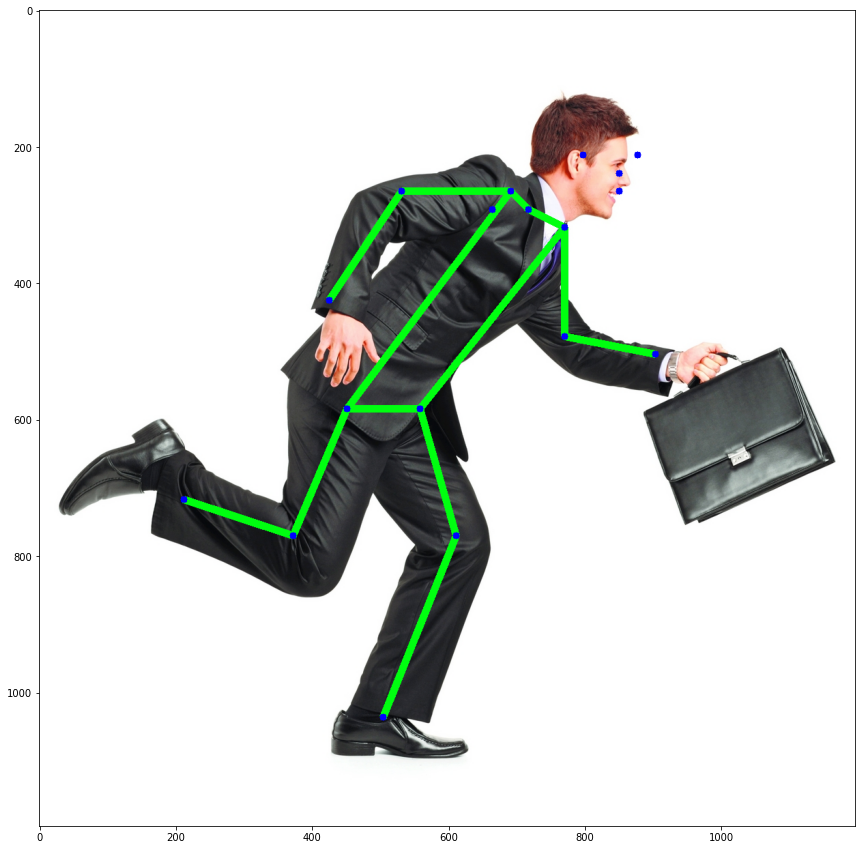

In [86]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
plt.imshow(imaga)